In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

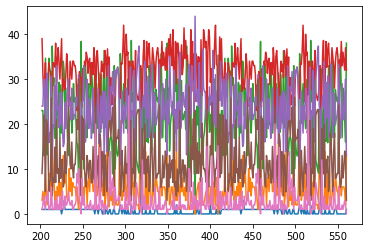

In [107]:
# import raw data and plot
data_set = pd.read_csv('Wordle.csv')
data_x = data_set.loc[:, ['Contest number']].values
data_y = data_set.iloc[:, 5:12].values
plt.plot(data_x, data_y)
plt.show()

In [108]:
data = data_y
data = data.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [109]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [110]:
reframed = series_to_supervised(data, 1, 1)
values = reframed.values
# Slice the test and training sets
train_size = int(len(values) * 0.75)
train = values[:train_size, :]
test = values[train_size:, :]
train_x, train_y = train[:, :-7], train[:, -7:]
test_x, test_y = test[:, :-7], test[:, -7:]

# print out their dimensions
print('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

train_x.shape, train_y.shape, test_x.shape, test_y.shape
(267, 7) (267, 7) (89, 7) (89, 7)


In [111]:
# initialize paraments
inp_dim = 7
out_dim = 7
mid_dim = 8
mid_layers = 1
batch_size = 49
mod_dir = '.'

In [112]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [113]:
#Slice
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence

batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [114]:
# 切换为训练模式，开始训练LSTM模型
net = net.train()
print("Training Start")
for e in range(2000):
    # 输入数据
    out = net(batch_var_x)
    # 预测值与真实值计算loss
    loss = criterion(out, batch_var_y)
    loss = loss.mean()
    # 优化函数根据loss进行优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
# 保存整个网络的参数至本地磁盘，评价时可以直接调取参数，无需再次训练
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 0.09758
Epoch:   64, Loss: 0.01021
Epoch:  128, Loss: 0.00976
Epoch:  192, Loss: 0.00951
Epoch:  256, Loss: 0.00893
Epoch:  320, Loss: 0.00594
Epoch:  384, Loss: 0.00451
Epoch:  448, Loss: 0.00402
Epoch:  512, Loss: 0.00368
Epoch:  576, Loss: 0.00331
Epoch:  640, Loss: 0.00294
Epoch:  704, Loss: 0.00257
Epoch:  768, Loss: 0.00234
Epoch:  832, Loss: 0.00214
Epoch:  896, Loss: 0.00201
Epoch:  960, Loss: 0.00195
Save in: ./net.pth


In [115]:
# 读取参数，切换到评价模式
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()
# 手动设置全部已知数据为初始测试数据，清空测试集部分的数据用作预测，然后在其后面添加60行零向量，预测之后60天的值
test_x = values[:, :-7]
test_x[train_size:, :] = 0
zeros = np.zeros((60, 7))
test_x = np.concatenate((test_x, zeros), axis=0)

test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
# 循环调用网络，把每次的预测值放入test_x里面，然后再把test_x作为数据放入网络中，最后预测出后面所有数据
for i in range(train_size, len(test_x)):
    tmp_y = net(test_x[:i])
    test_x[i] = tmp_y[-1]

In [118]:
np.shape(test_x)

torch.Size([416, 1, 7])

In [116]:
# 反归一化，并且获取预测值，这样输出的就是之前的百分数了，即每一行7个数加起来约等于100
test_x_percent = test_x[:, 0, :]
test_x_percent = test_x_percent.cpu().data.numpy()
pred_known = test_x_percent[train_size:len(data) - 1]
r_2 = []
for i in range(len(pred_known[0])):
    pred = pred_known[:, i].reshape(len(pred_known))
    true = test_y[:, i].reshape(len(pred_known))
    r_2.append(r2_score(pred, true))
print(f"r 2: {r_2}")
test_x_percent = scaler.inverse_transform(test_x_percent)
test_x_percent = np.around(test_x_percent)
pred_y = test_x_percent[train_size:]
pred_known_percent = pred_y[:len(values) - train_size]  # 为测试部分
pred_unknown_percent = pred_y[len(values) - train_size:]  # 为预测部分

r 2: [-1459.723911732968, -14.088212953530231, -6.276456563395541, -4.998380338540606, -5.947181756114015, -3.4540069531024713, -8.708702257370605]


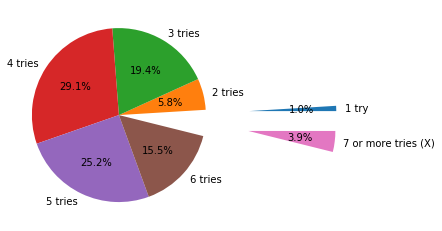

In [117]:
pred_unknown_percent[pred_unknown_percent < 0] = 0
label = ["1 try", "2 tries", "3 tries", "4 tries", "5 tries", "6 tries", "7 or more tries (X)"]
expld = [1.5, 0, 0, 0, 0, 0, 1.5]
plt.pie(pred_unknown_percent[59], explode=expld, labels=label, autopct='%3.1f%%')
plt.show()